In [234]:
import cv2

import mediapipe as mp

#进度条库
from tqdm import tqdm

import time

import numpy as np

import threading

In [235]:
mp_face_mesh = mp.solutions.face_mesh
model = mp_face_mesh.FaceMesh(
    static_image_mode=False,       #是静态图片还是连续视频帧
    refine_landmarks=True,        #使用Attention Mesh模型，对嘴唇、眼睛、瞳孔周围的关键点精细定位
    max_num_faces=1,               #最多检测几张脸
    min_detection_confidence=0.5,  #置信度阈值，越接近1越准
    min_tracking_confidence=0.5    #追踪阈值
)
#导入可视化函数和可视化样式
mp_drawing = mp.solutions.drawing_utils
#关键点可视化样式
landmark_drawing_spec = mp_drawing.DrawingSpec(thickness = 1,circle_radius = 2,color = [66,77,229])
#轮廓可视化样式
connection_drawing_spec = mp_drawing.DrawingSpec(thickness = 2,circle_radius = 1,color = [223,155,6])

In [236]:
#计算左、右眼EAR值以及平均值
def computerEar(face_landmarks,height,width):
    dics = [33,161,157,133,154,163,362,384,388,263,390,381]
    pointarr = []
    print(type(pointarr))
    for dic in dics:
        cx = int(face_landmarks.landmark[dic].x * width)
        cy = int(face_landmarks.landmark[dic].y * height)
        pointarr.append([cx,cy])
        #cv2.circle(img, (cx, cy), 5, (0, 0, 255))
        #img = cv2.putText(img,str(dic),(cx,cy),cv2.FONT_HERSHEY_SIMPLEX,1*scaler,(0,255,0),1)
    pointarr = np.array(pointarr)

    #计算左眼ear
    A = np.linalg.norm(pointarr[1]-pointarr[5])
    B = np.linalg.norm(pointarr[2]-pointarr[4])
    C = np.linalg.norm(pointarr[0]-pointarr[3])
    leftear = (A + B) / (2.0 * C) 
    leftear = round(leftear,2)
    #计算右眼ear
    D = np.linalg.norm(pointarr[7]-pointarr[11])
    E = np.linalg.norm(pointarr[8]-pointarr[10])
    F = np.linalg.norm(pointarr[6]-pointarr[9])
    rightear = (D + E) / (2.0 * F) 
    rightear = round(rightear,2)
    avaear = (leftear+rightear)/2
    return leftear,rightear,avaear

In [237]:
def computermouthear(face_landmarks,height,width):
    #dics = [62,39,269,306,405,181]
    dics = [62,80,310,306,318,88]
    pointarr = []
    for dic in dics:
        cx = int(face_landmarks.landmark[dic].x * width)
        cy = int(face_landmarks.landmark[dic].y * height)
        pointarr.append([cx,cy])
        #cv2.circle(img, (cx, cy), 5, (0, 0, 255))
        #img = cv2.putText(img,str(dic),(cx,cy),cv2.FONT_HERSHEY_SIMPLEX,1*scaler,(0,255,0),1)
    pointarr = np.array(pointarr)
    #计算Mouth ear
    A = np.linalg.norm(pointarr[1]-pointarr[5])
    B = np.linalg.norm(pointarr[2]-pointarr[4])
    C = np.linalg.norm(pointarr[0]-pointarr[3])
    mouthear = (A + B) / (2.0 * C) 
    mouthear = round(mouthear,2)
    return mouthear

In [238]:
# 处理函数
def process_frame(img):
    #记录该帧开始处理的时间
    start_time = time.time()
    scaler = 1 #文字大小
    h,w = img.shape[0],img.shape[1]
    #BGR转RGB
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # 将RGB图像输入模型 获取预测结果
    results = model.process(img)

    avaear = 1000
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            #绘制人脸网格
            mp_drawing.draw_landmarks(
                image = img,
                landmark_list = face_landmarks,
                #connections = mp_face_mesh.FACEMESH_TESSELATION,# 可视化Face Mesh
                connections = mp_face_mesh.FACEMESH_CONTOURS,# 可视化脸轮廓
                #landmark_drawing_spec 为关键点可视化样式 None为默认值（不显示关键点）
                #landmark_drawing_spec= mp_drawing.DrawingSpec(thickness=1,circle_radius=2,color=[66,77,229])
                landmark_drawing_spec = landmark_drawing_spec,#关键点圆圈样式
                connection_drawing_spec = connection_drawing_spec#轮廓样式
            )
            # dics = [62,80,310,306,318,88]
            # pointarr = []
            # for dic in dics:
            #     cx = int(face_landmarks.landmark[dic].x * w)
            #     cy = int(face_landmarks.landmark[dic].y * h)
            #     pointarr.append([cx,cy])
            #     cv2.circle(img, (cx, cy), 5, (0, 0, 255))
                #img = cv2.putText(img,str(dic),(cx,cy),cv2.FONT_HERSHEY_SIMPLEX,1*scaler,(0,255,0),1)
            # indexnum = 0
            # for idx,coord in enumerate(face_landmarks.landmark): #遍历每一个关键点
            #     indexnum += 1
            #     if indexnum>300 and indexnum < 320:
            #         # 图片，添加的文字，左上角坐标，字体，字体颜色，颜色，字体粗细
            #         cx = int(coord.x * w)
            #         cy = int(coord.y * h)
            #         img = cv2.putText(img,'Face Detected',(25*scaler,50*scaler),cv2.FONT_HERSHEY_SIMPLEX,1.25*scaler,(255,0,255),2*scaler)
            #         img = cv2.putText(img,str(idx),(cx,cy),cv2.FONT_HERSHEY_SIMPLEX,0.3*scaler,(0,255,0),1)
        
            img = cv2.putText(img,'Face Detected',(25*scaler,50*scaler),cv2.FONT_HERSHEY_SIMPLEX,1.25*scaler,(255,0,255),2*scaler)
            leftEar,rightEar,averageEar =computerEar(face_landmarks,h,w)
            cv2.putText(img, "Left Eye Aspect Ratio:{}".format(str(leftEar)), (30*scaler,150*scaler), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(img, "Right Eye Aspect Ratio:{}".format(str(rightEar)), (30*scaler,200*scaler), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(img, "Average Eye Aspect Ratio:{}".format(str(averageEar)), (30*scaler,250*scaler), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
            mouthear = computermouthear(face_landmarks,h,w)
            cv2.putText(img, "Mouth Aspect Ratio:{}".format(str(mouthear)), (30*scaler,300*scaler), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
    else:
        img = cv2.putText(img,"No Face Detected",(25*scaler,50*scaler),cv2.FONT_HERSHEY_SIMPLEX,1.25*scaler,(255,0,255),2*scaler)

    #记录该帧处理完毕时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time-start_time)

    img = cv2.putText(img,'FPS  '+str(int(FPS)),(25*scaler,100*scaler),cv2.FONT_HERSHEY_SIMPLEX,1.25*scaler,(255,0,255),2*scaler)

    return img,avaear

33左眼左眼角      362右眼左眼角
133左眼右眼角     263右眼右眼角


In [239]:
import matplotlib.pyplot as plt
#使用ipython的魔法方法，将绘制的图像直接嵌入在notebook单元格中
%matplotlib inline

def look_img(img):
    img_RGB = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()

<class 'list'>


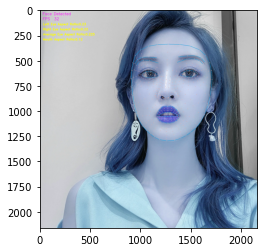

True

In [240]:
rawimg = cv2.imread('data/4.jpg')
processimg,ava = process_frame(rawimg)
look_img(processimg)
cv2.imwrite('4_out.jpg',processimg)

In [241]:
# import cv2
# import time

# # 眨眼最小阈值  触发报警的眼睛纵横比的最小阈值
# eyes_blink = 0.1
# # 眼睛比率低于触发警报阈值的最小连续帧
# eyes_ratio = 50

# cap = cv2.VideoCapture(0)
# cap.open(0)
# #无限循环，知道break被触发
# while cap.isOpened():
#     success ,frame = cap.read()
#     if not success:
#         print('ERROR')
#         break

#     ### 处理帧函数
#     frame,curavaear = process_frame(frame)
#     #展示处理后的三通道图像
#     cv2.imshow('my_window',frame)
#     if cv2.waitKey(1) in [ord('q'),27]: # 按键盘上的q或者esc退出（在英文输入法下）
#         break

# # 关闭摄像头
# cap.release()

# # 关闭图像窗口
# cv2.destroyAllWindows()